In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

import json

from os.path import join

In [2]:
user_csv_path = './user_df.csv'
user_df = pd.read_csv(user_csv_path)
# uid -> user id
# nid -> node id
uid_nid_map = {}
def add_uid_nid_mapping(uid_nid_map, uid, nid):
    uid_nid_map[uid] = nid
    return nid

In [3]:
user_df['node_id'] = user_df.apply(lambda row: add_uid_nid_mapping(uid_nid_map, row['user_id'], row.name), axis = 1)
nid_uid_map = {nid: uid for (uid, nid) in uid_nid_map.items()}
nid_list = user_df['node_id'].tolist()
# This creates a graph in which there is an undirected edge between each of the nodes
user_graph = nx.complete_graph(len(nid_list))

In [4]:
# Add the node attributes to the graph
node_attrs_dict = {}
for nid in nid_list:
    row = user_df.iloc[nid]
    num_listens, listening_duration = row['num_listens'], row['listening_duration']
    song_map = json.loads(row['song_map'].replace("\'", "\""))
    artist_map = json.loads(row['artist_map'].replace("\'", "\""))
    node_attributes = {
        'num_listens': num_listens, 
        'listening_duration': listening_duration, 
        'song_map': song_map,
        'artist_map': artist_map
                      }
    node_attrs_dict[nid] = node_attributes
nx.set_node_attributes(user_graph, node_attrs_dict)

Create a fully connected undirected graph by adding edges between each of the nodes with edge features of dissimilarity. We use dissimilarity as the edge weights such that for an edge feature the users who have dissimilar listening preferences will share a larger weight along the edge for that feature and smaller weights for higher similarity.

In [5]:
# create edge attributes and add them to the graph
edge_attribute_list = []
for nid in nid_list[:-1]:
    for other_nid in nid_list[nid+1:]:
        nid_attr_dict, other_nid_attr_dict = user_graph.nodes[nid], user_graph.nodes[other_nid]
        num_listens_abs_diff = abs(nid_attr_dict['num_listens'] - other_nid_attr_dict['num_listens'])
        listening_dur_abs_diff = abs(nid_attr_dict['listening_duration'] - other_nid_attr_dict['listening_duration'])
        edge_attr_dict = {
            'num_listens_abs_diff': num_listens_abs_diff,
            'listening_dur_abs_diff': listening_dur_abs_diff
        }
        edge = (nid, other_nid, edge_attr_dict)
        edge_attribute_list.append(edge)
user_graph.add_edges_from(edge_attribute_list)

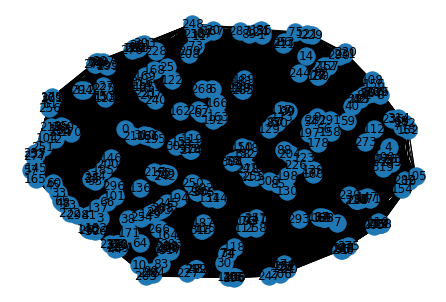

In [9]:
nx.draw(user_graph, with_labels=True)
plt.savefig('test_graph_draw.png')